## Import libraries

In [110]:
import numpy as np
import pandas as pd
import os
import re
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch

print("Pytorch: " + "GPU" if torch.cuda.is_available() else "CPU")

Pytorch: GPU


In [111]:
model = torch.hub.load("./yolov5", "custom", source='local', path="./modelSaves/best.pt", force_reload=True)

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.15 torch-1.7.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [112]:
filepath = "coco_person_dataset/coco_downloaded_images/000000012120.jpg"

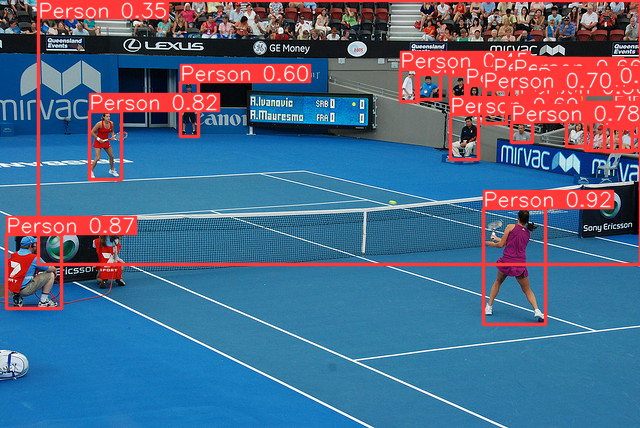

In [113]:
res = model(filepath)
res.show()

In [114]:
res = pd.DataFrame(res.xywh[0].cpu().numpy(), columns=["x", "y", "w", "h", "confidence", "label"])

In [115]:
print(res.sort_values(by=["confidence"], ascending=False))

             x           y           w           h  confidence  label
0   514.882141  266.604889   62.173096  115.583984    0.919997    0.0
1    34.130737  271.558655   54.408340   73.905411    0.873387    0.0
2   105.159088  145.474701   32.020599   68.621223    0.822207    0.0
3   522.227112  132.377625   20.592072   19.255096    0.775106    0.0
4   495.284119  106.347641   23.145508   33.389366    0.695447    0.0
5   464.760132  137.195328   28.459351   44.418640    0.693059    0.0
6   548.530273   97.869385   21.524170   25.864319    0.681057    0.0
7   525.476318   88.683685   23.930054   23.771011    0.664444    0.0
8   502.540466   90.229782   17.706360   29.263412    0.636434    0.0
9   189.200043  109.518158   17.790649   53.630157    0.601450    0.0
10  579.170654  133.114532   25.153076   26.773102    0.560049    0.0
11  629.920227  137.903412   19.646973   26.061890    0.557438    0.0
12  475.391632   98.392410   20.093079   26.151962    0.515650    0.0
13  598.266907  135.

### handle results configuration

In [116]:
res["x"] = res.apply(lambda x:x["x"]+(x["w"]/2), axis=1)
res["y"] = res.apply(lambda x:x["y"]+(x["h"]/2), axis=1)
min_w = res["w"].min()
res["w"] = res.apply(lambda x:(x["w"]/min_w)**2, axis=1)

res = res[res["confidence"]>=0.35][["x", "y", "w"]]
print(res)

             x           y          w
0   545.968689  324.396881  50.626420
1    61.334908  308.511360  38.770660
2   121.169388  179.785313  13.428613
3   532.523148  142.005173   5.553571
4   506.856873  123.042324   7.016260
5   478.989807  159.404648  10.607724
6   559.292358  110.801544   6.067713
7   537.441345  100.569191   7.499971
8   511.393646  104.861488   4.106112
9   198.095367  136.333237   4.145299
10  591.747192  146.501083   8.286182
11  639.743713  150.934357   5.055493
12  485.438171  111.468391   5.287680
13  611.149536  150.431152   8.694433
14  584.495667  117.087837   4.355649
15  418.210358  101.767227   3.920076
16  468.823273  105.579552   4.558668
17  632.137817  151.606873   9.684789
18  573.199158  115.370461   3.993018
19  538.162964  115.316193   4.806411


## Implement clustering

In [117]:
RAND_SEED = 3362
from sklearn.cluster import KMeans

In [118]:
kmeans = KMeans(
    n_clusters = 3, 
    init = 'random',
    n_init = 10,
)

In [119]:
arr = res.to_numpy()
kmeans.fit(arr)

KMeans(init='random', n_clusters=3)

In [120]:
preds = kmeans.predict(arr)

## Visualize Clustering result

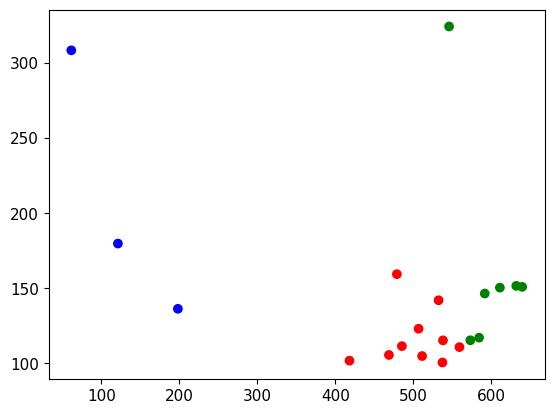

In [121]:
# Visualizing predictions with Seaborn pairplot
import matplotlib.pyplot as plt
%matplotlib inline

colors_ = ["green", "blue", "red", "yellow", "purple"]
plt.scatter(arr[:,0], arr[:,1], c=[colors_[i] for i in preds.tolist()])

plt.show()

## Determine cluster density

In [122]:
tmp = (pd.DataFrame(((res[["x", "y", "w"]].groupby(by=preds).max() - res[["x", "y", "w"]].groupby(by=preds).min()).apply(lambda x: x.x * x.y * x.w, axis=1)), columns=["w"])).rename(columns={"w":"area"})
density = ((pd.DataFrame(res[["w"]].groupby(by=preds).size(), columns=["area"])/tmp)/(res[["w"]].groupby(by=preds).mean()).rename(columns={'w':"area"})).rename(columns={"area":"density"})
density

,density
0,5.910477e-07
1,1.959105e-07
2,3.031465e-05


Create Label to identify if area is crowded
    Threshold to determine if area is crowded

In [123]:
crowded = density.copy()
crowded["label"] = density.apply(lambda x: x>5.910477e-07)
crowded

,density,label
0,5.910477e-07,True
1,1.959105e-07,False
2,3.031465e-05,True
